# MRI vs MRI+Histo-Aligned: UMAP & Silhouette Comparison

This notebook loads **two** MRI encoding datasets (e.g., baseline MRI vs MRI aligned with histopathology), projects both to 2D with UMAP using the same hyperparameters & color palette (if found in your histopath notebook), computes silhouette scores on the **full encodings** and **UMAP-2D** for each, and displays side-by-side UMAP plots.

In [ ]:
# --- Paths (EDIT ME) ---
ENC =  512
ENC_DIR_A = f"/home/ewillis/projects/aip-medilab/ewillis/pca_contrastive/mri_model_medsam_finetune_2D/PATIENT_LEVEL/RESULTS_MERGED_PATIENT_LEVEL/isup3/results512/baseline/encodings_val_f0"
ENC_DIR_B = f"/home/ewillis/projects/aip-medilab/ewillis/pca_contrastive/mri_model_medsam_finetune_2D/PATIENT_LEVEL/RESULTS_MERGED_PATIENT_LEVEL/isup3/results512/TRIPLET/karolinska_only/head_only_karolinska/encodings_val_f0"
NAME_A = "Train set: Baseline MRI"
NAME_B = "Train set: Triplet Loss Aligned (Karolinska Only)"

EMB_A = f"{ENC_DIR_A}/val_embeddings.npy"
LAB_A = f"{ENC_DIR_A}/val_labels.npy"
META_A = f"{ENC_DIR_A}/val_metadata.csv"

EMB_B = f"{ENC_DIR_B}/val_embeddings.npy"
LAB_B = f"{ENC_DIR_B}/val_labels.npy"
META_B = f"{ENC_DIR_B}/val_metadata.csv"

# --- UMAP hyperparameters (auto-extracted when possible, else defaults) ---
UMAP_PARAMS = {
  "n_neighbors": 15,
  "min_dist": 0.1,
  "metric": "cosine",
  "random_state": 42,
  "n_components": 2
}

# --- Color palette ---
# If a palette was found in the histopath notebook, it's injected below. Otherwise a default is built at runtime per label id.
COLORS = None  # will be built based on labels if None


print(5)

5


In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
try:
    import umap.umap_ as umap
except Exception as e:
    raise RuntimeError("Please install umap-learn: pip install umap-learn")


In [78]:
def load_encodings(emb_path, lab_path, meta_path):
    emb = np.load(emb_path)
    labels = np.load(lab_path)
    meta = pd.read_csv(meta_path)
    assert emb.shape[0] == labels.shape[0] == len(meta), "Row count mismatch among embeddings/labels/meta"
    return emb, labels, meta

def build_palette(labels, COLORS=None):
    uniq = sorted(pd.unique(labels))
    label_names_6 = {0: 'ISUP_0', 1:'ISUP_1', 2:'ISUP_2', 3:'ISUP_3', 4:'ISUP_4', 5:'ISUP_5'}
    label_names_3 = {0: 'ISUP01', 1:'ISUP23', 2:'ISUP45'}
    label_names = label_names_3 if len(uniq) <= 3 else label_names_6
    if isinstance(COLORS, dict) and len(COLORS) > 0:
        from itertools import cycle
        default_colors = cycle(plt.rcParams['axes.prop_cycle'].by_key().get('color', []))
        palette = {int(k): COLORS.get(int(k), None) for k in uniq}
        for k in uniq:
            if palette[int(k)] is None:
                palette[int(k)] = next(default_colors)
    else:
        from itertools import cycle
        cyc = cycle(plt.rcParams['axes.prop_cycle'].by_key().get('color', []))
        palette = {int(k): next(cyc) for k in uniq}
    return palette, label_names


In [79]:
# --- Load both datasets ---
embA, yA, metaA = load_encodings(EMB_A, LAB_A, META_A)
embB, yB, metaB = load_encodings(EMB_B, LAB_B, META_B)
print(NAME_A, embA.shape, '|', NAME_B, embB.shape)
assert set(pd.unique(yA)) == set(pd.unique(yB)), "Label sets differ; palette may misalign. Consider remapping."
labels_all = sorted(set(pd.unique(yA)))


Val set: Baseline MRI (6696, 512) | Val set: Triplet Loss Aligned (Karolinska Only) (6696, 512)


In [80]:
# --- Build a single palette for both datasets to keep colors consistent ---
palette, label_names = build_palette(np.array(labels_all), COLORS if 'COLORS' in globals() else None)
palette

{0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c'}

In [81]:
# --- Silhouette on FULL encodings (each dataset standardized separately) ---
scA = StandardScaler(); XA = scA.fit_transform(embA)
scB = StandardScaler(); XB = scB.fit_transform(embB)
silA_euc_full = silhouette_score(XA, yA, metric='euclidean')
silA_cos_full = silhouette_score(XA, yA, metric='cosine')
silB_euc_full = silhouette_score(XB, yB, metric='euclidean')
silB_cos_full = silhouette_score(XB, yB, metric='cosine')
print(NAME_A, f"FULL (cos): {silA_cos_full:.3f} | (euc): {silA_euc_full:.3f}")
print(NAME_B, f"FULL (cos): {silB_cos_full:.3f} | (euc): {silB_euc_full:.3f}")

Val set: Baseline MRI FULL (cos): -0.001 | (euc): 0.076
Val set: Triplet Loss Aligned (Karolinska Only) FULL (cos): -0.035 | (euc): -0.081


In [84]:
# --- UMAP to 2D (fit separately for each dataset with identical hyperparameters) ---
reducerA = umap.UMAP(**UMAP_PARAMS)
reducerB = umap.UMAP(**UMAP_PARAMS)
XA2 = reducerA.fit_transform(XA)
XB2 = reducerB.fit_transform(XB)
silA_euc_2d = silhouette_score(XA2, yA, metric='euclidean')
silA_cos_2d = silhouette_score(XA2, yA, metric='cosine')
silB_euc_2d = silhouette_score(XB2, yB, metric='euclidean')
silB_cos_2d = silhouette_score(XB2, yB, metric='cosine')
print(NAME_A, f"UMAP2D (cos): {silA_cos_2d:.3f} | (euc): {silA_euc_2d:.3f}")
print(NAME_B, f"UMAP2D (cos): {silB_cos_2d:.3f} | (euc): {silB_euc_2d:.3f}")

/home/ewillis/projects/aip-medilab/ewillis/pca_contrastive/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/ewillis/projects/aip-medilab/ewillis/pca_contrastive/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Val set: Baseline MRI UMAP2D (cos): 0.018 | (euc): 0.026
Val set: Triplet Loss Aligned (Karolinska Only) UMAP2D (cos): 0.231 | (euc): 0.011


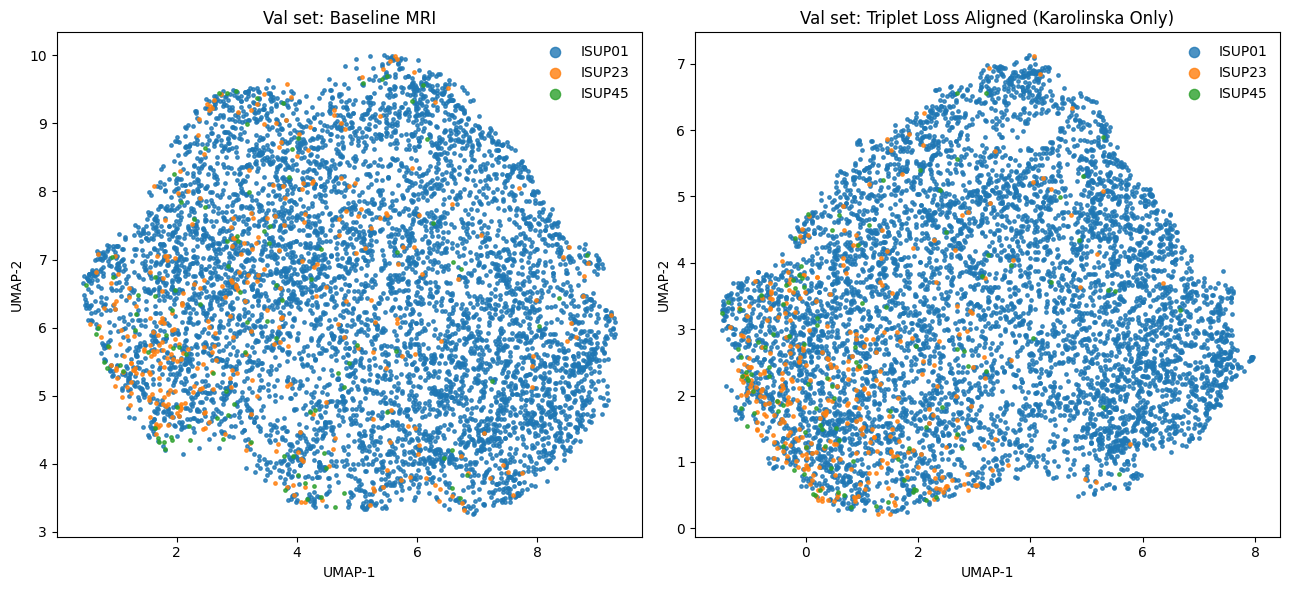

In [87]:
# --- Side-by-side UMAP plots ---
fig, axes = plt.subplots(1, 2, figsize=(13,6), sharex=False, sharey=False)
for ax, X2, y, name in [(axes[0], XA2, yA, NAME_A), (axes[1], XB2, yB, NAME_B)]:
    for k in sorted(pd.unique(y)):
        m = (y == k)
        ax.scatter(X2[m,0], X2[m,1], s=6, alpha=0.8, label=label_names.get(int(k), str(k)), c=palette[int(k)])
    ax.set_title(f"{name}")
    ax.set_xlabel('UMAP-1'); ax.set_ylabel('UMAP-2')
    ax.legend(markerscale=3, frameon=False, loc='best')
plt.tight_layout()
# plt.savefig(f"{ENC_DIR_A}/compare_umap_side_by_side.png", dpi=200)
plt.show()

In [88]:
# --- Summary table ---
summary = pd.DataFrame([
    [NAME_A, 'full', 'cosine',    silA_cos_full],
    [NAME_A, 'full', 'euclidean', silA_euc_full],
    [NAME_A, 'umap2d', 'cosine',    silA_cos_2d],
    [NAME_A, 'umap2d', 'euclidean', silA_euc_2d],
    [NAME_B, 'full', 'cosine',    silB_cos_full],
    [NAME_B, 'full', 'euclidean', silB_euc_full],
    [NAME_B, 'umap2d', 'cosine',    silB_cos_2d],
    [NAME_B, 'umap2d', 'euclidean', silB_euc_2d],
], columns=['dataset','space','metric','silhouette'])
summary_pivot = summary.pivot_table(index='dataset', columns=['space','metric'], values='silhouette')
display(summary_pivot)
# summary.to_csv(f"{ENC_DIR_A}/compare_umap_silhouette_raw.csv", index=False)
# summary_pivot.to_csv(f"{ENC_DIR_A}/compare_umap_silhouette_wide.csv")
summary_pivot

space                                               full              umap2d  \
metric                                            cosine euclidean    cosine   
dataset                                                                        
Val set: Baseline MRI                           -0.00101  0.076177  0.017954   
Val set: Triplet Loss Aligned (Karolinska Only) -0.03505 -0.081145  0.231342   

space                                                      
metric                                          euclidean  
dataset                                                    
Val set: Baseline MRI                            0.026067  
Val set: Triplet Loss Aligned (Karolinska Only)  0.011367

space                                               full              umap2d  \
metric                                            cosine euclidean    cosine   
dataset                                                                        
Val set: Baseline MRI                           -0.00101  0.076177  0.017954   
Val set: Triplet Loss Aligned (Karolinska Only) -0.03505 -0.081145  0.231342   

space                                                      
metric                                          euclidean  
dataset                                                    
Val set: Baseline MRI                            0.026067  
Val set: Triplet Loss Aligned (Karolinska Only)  0.011367